In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
from vqls import *
from utils import *


file_path = "results_tanh_3.json"

In [12]:
df = pd.read_json(file_path)

np.mean(df.exe_time/60/60)


0.4824573687315056

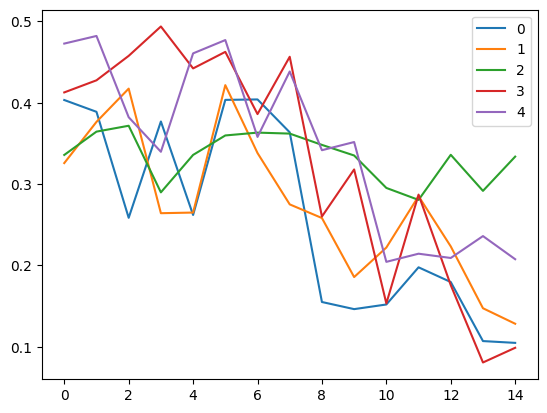

In [13]:
#Visualize training cost and obtain best performing epoch
argM = []
for i,item in enumerate(df["training_cost"].values):
    argM.append(np.argmin(item))
    plt.plot(item, label = i)
plt.legend()

In [14]:
## experimental specific settings
label = 'tanh'
nq = 3
n_step = 8

In [15]:

func_out = {'sigmoid': sigmoid_t,'tanh': tanh_t,'elu': elu_t, 'relu': relu_t, 'sin':sin_m}
func = func_out[label]


#############################################################################################
###################################### System Preparatio and _sin_#################
#############################################################################################

lower = 0. 
upper = 1. 
f_i = 0.0 
scaled=False
x = np.arange(lower, upper + .03, (upper-lower)/n_step).tolist() 
xx = np.linspace(lower, upper, n_step) ##inputs sampling in the interval 0,1
y = [func(value,f_i) for value in x]

if scaled:
    norm = np.linalg.norm(y)
    y = y / norm

tck=splrep(x,y,k=1) #coeffs
matrix,vector,v_norm = GeneralizedVQS_System(n_step,label,x,xx,scaled=scaled)


#############################################################################################
################################# VQLS and Linear Prob. Solving #############################
#############################################################################################


k_numb=np.linalg.cond(np.array(matrix))

vqls_circuit = VQLS(matrix,v_norm,nq,opt='COBYLA') 


beta_classic                 : [ 0.11920292  0.24295564 -0.10448426  1.30398885 -0.73752719  1.55230194
  0.36196794  0.88079708]


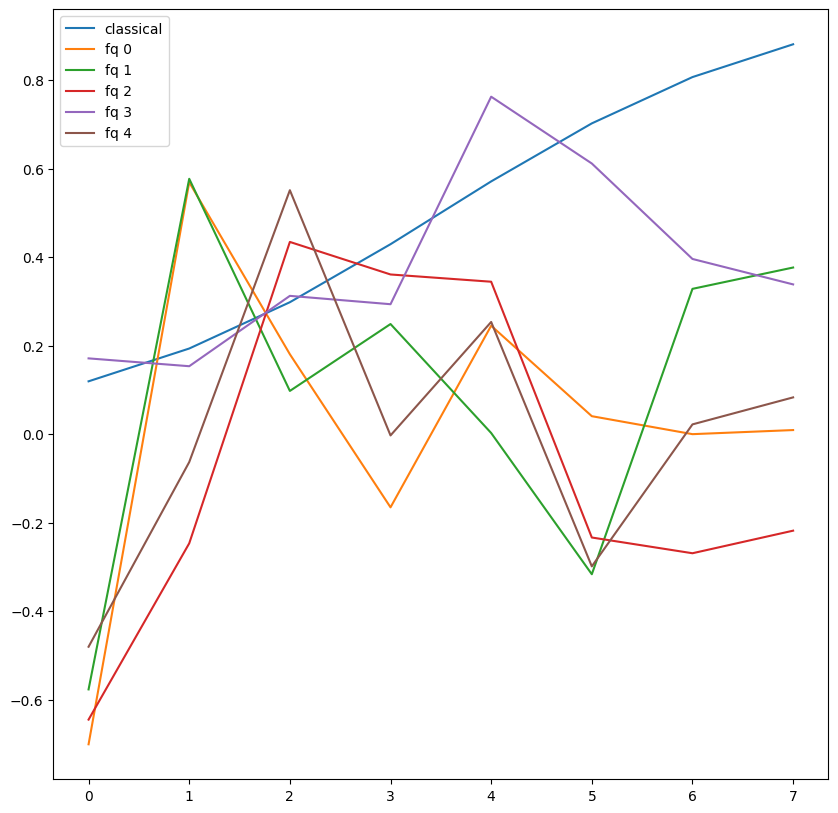

In [16]:
c = np.linalg.solve(matrix,vector)
print('beta_classic                 :',c)
plt.figure(figsize=(10,10))

y_c=np.dot(matrix,c) #classic
plt.plot(range(len(y_c)),y_c, label="classical")

for i,item in enumerate(df['in_train_weights']):
  weights = item[argM[i]]
  q = vqls_circuit.solution(weights).real
  y_q=np.dot(matrix,q) #hybrid
                        #Quantum

  y_fq=[]
  for el in matrix:
    y_fq.append(vqls_circuit.direct_prod2(weights,el))

  #plt.plot(range(len(y_fq)),y_q,label= f"h {i}")
  plt.plot(range(len(y_fq)),y_fq, label= f"fq {i}")
plt.legend()

In [17]:
best = np.argmin(df['RSS_q'])
weights = df['in_train_weights'][best][argM[best]]

weights

[0.8678702664,
 2.9355009347000003,
 0.1211948941,
 0.3930243453,
 0.6071489946,
 4.2178897015,
 2.2028561143,
 4.5976353381,
 -0.17285730130000002]

3


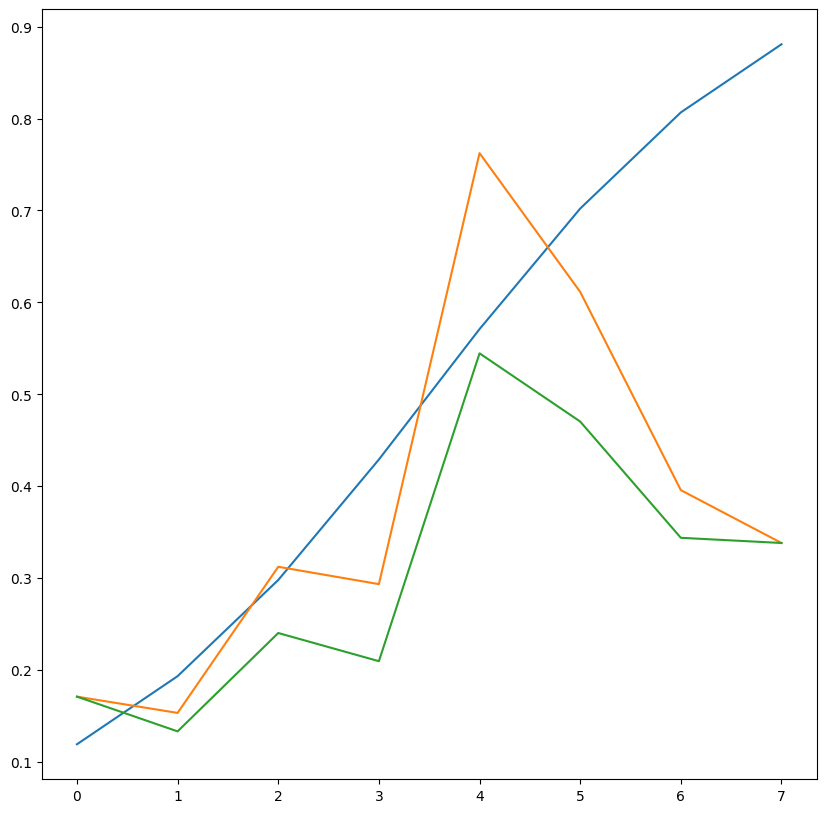

In [18]:
#Best performing model based on RSS

best = np.argmin(df['RSS_q'])
print(best)
weights = df['in_train_weights'][best][argM[best]]
q = vqls_circuit.solution(weights).real
y_q=np.dot(matrix,q) #hybrid
                  #Quantum
plt.figure(figsize=(10,10))
plt.plot(range(len(y_c)),y_c, label="classical")

y_fq=[]
for el in matrix:
  y_fq.append(vqls_circuit.direct_prod2(weights,el))

#plt.plot(range(len(y_fq)),y_q,label= f"h {i}")
plt.plot(range(len(y_fq)),y_fq, label= f"fq {best}");
plt.plot(range(len(y_fq)),y_q, label= f"hq {best}");
